In [6]:
import tensorflow as tf
import pandas as pd
import datetime
import matplotlib.pyplot as plt

import sys
sys.path.append('./rtaUtils')

from rtaUtils import paths, experiment, data_loading

import wandb, os
from wandb.keras import WandbCallback
os.environ["WANDB_SILENT"] = "true"

tf.config.set_visible_devices([], 'GPU')
visible_devices = tf.config.get_visible_devices()
print(visible_devices)
for device in visible_devices:
    assert device.device_type != 'GPU'
    
### Features ##################################################################
numeric_feat = [
    'latitude', 'longitude', 'altitude', 'departureDelay', 'vspeed', 'speed', 
    'day_of_week', 'track', 'wind_dir_degrees', 'wind_speed_kt', 
    'visibility_statute_mi', 'max_temp', 'min_temp', 'clouds', 'hav_distance'
]
categoric_feat = [
    'time_of_day', 'operator', 'aerodromeOfDeparture', 'sky_status'
]
objective = ['RTA']

ts_features = [
    'latitude', 'longitude', 'altitude', 'vspeed', 'speed', 'track', 'hav_distance'
]
nts_features = [
    'departureDelay', 'day_of_week', 'wind_dir_degrees','wind_speed_kt', 
    'visibility_statute_mi', 'max_temp', 'min_temp', 'time_of_day', 'operator', 
    'aerodromeOfDeparture', 'sky_status', 'clouds'
]

feat_dict = dict(
    numeric=numeric_feat,
    categoric=categoric_feat,
    objective=objective,
    ts=ts_features,
    nts=nts_features
)

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]


In [7]:
### Experiment setup ##########################################################
n_units      = 20
lookback     = 128
sampling     = 30

epochs       = 30

act_function = 'tanh'
batch_size   = 128
from_parquet = True

model_config = dict(
    n_units=n_units,
    act_function=act_function,
    batch_size=batch_size,
)

### Model configuration #######################################################
model_type   = 'LSTM'
months       = '*' # 20220[12]
airport      = '*'
glob_text    = f'{months}-{airport}'

In [8]:
dt = datetime.datetime.now().strftime('%m%d_%H%M')

wandb_config = {
    'batch_size' : batch_size,
    'lookback' : lookback,
    'n_units' : n_units,
    'sampling' : sampling,
    'model_type' : model_type
}
wandb.init(project='RTAs', config=wandb_config,
           name=f'{model_type}_s{sampling}_lb{lookback}_u{n_units}_{dt}'           
           # resume='must', id=''
          ) 
wandCallback = WandbCallback(save_model=False)

## Entrenamiento

In [9]:
experimento = experiment.ExperimentVanilla(
    lookback=lookback,
    sampling=sampling,
    model_config=model_config,
    months=months, 
    airport=airport,
    features=feat_dict
)
experimento.init_model()
# experimento.load_model()
experimento.model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 20)                3200      
                                                                 
 dense_1 (Dense)             (None, 1)                 21        
                                                                 
Total params: 3,221
Trainable params: 3,221
Non-trainable params: 0
_________________________________________________________________


In [10]:
history = experimento.train(epochs=epochs, from_parquet=from_parquet, add_callbacks = [wandCallback]) 
# add_callbacks = [wandCallback]

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089
Epoch 1/30
7981/7981 [==============================] - 1193s 147ms/step - loss: 0.0086 - mean_squared_error: 3.4318e-04 - val_loss: 0.0102 - val_mean_squared_error: 2.0578e-04
Epoch 2/30
7981/7981 [==============================] - 28938s 4s/step - loss: 0.0068 - mean_squared_error: 1.4279e-04 - val_loss: 0.0101 - val_mean_squared_error: 2.1585e-04
Epoch 3/30
7981/7981 [==============================] - 1131s 141ms/step - loss: 0.0065 - mean_squared_error: 1.3480e-04 - val_loss: 0.0081 - val_mean_squared_error: 1.5681e-04
Epoch 4/30
7981/7981 [==============================] - 1215s 151ms/step - loss: 0.0063 - mean_squared_error: 1.3018e-04 - val_loss: 0.0086 - val_mean_squared_error: 1.6807e-04
Epoch 5/30
7981/7981 [==============================] - 1114s 139ms/step - loss: 0.0062 - mea

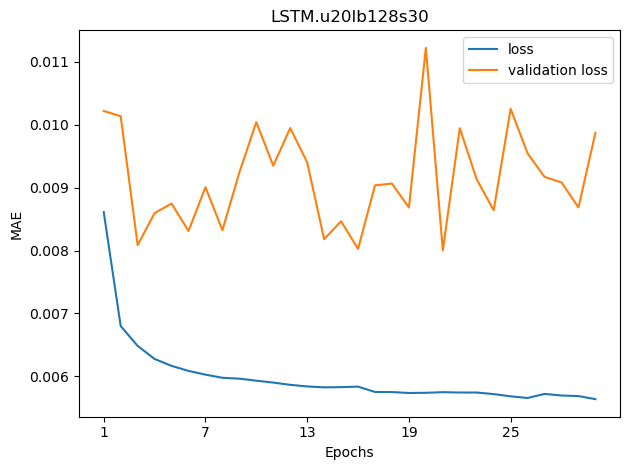

In [11]:
progress = pd.read_csv(experimento.model_path_log)
skip = 0

plt.plot([str(x) for x in range(1+skip,progress.shape[0]+1)], progress['loss'].iloc[skip:], label='loss')
plt.plot([str(x) for x in range(1+skip,progress.shape[0]+1)], progress['val_loss'].iloc[skip:], label='validation loss')
plt.title(f'{model_type}.u{n_units}lb{lookback}s{sampling}')
plt.xlabel('Epochs')
plt.ylabel('MAE')
if progress.shape[0]>10:
    plt.xticks([str(x) for x in range(1+skip,progress.shape[0],progress.shape[0]//5)])
plt.legend()
plt.tight_layout()
plt.show()

## Evaluación

In [12]:
experimento.load_model('best')

1427/1427 [==============================] - 146s 102ms/step
Val set           | MAE:        179.067s
                  | RMSE:       266.533s
                  | StDev:      266.310s
                  | Mean:       -10.928s
                  | MAPE:         0.190
                  | Muestra:    182,556
1664/1664 [==============================] - 152s 91ms/step
Test set          | MAE:        184.503s
                  | RMSE:       288.284s
                  | StDev:      288.096s
                  | Mean:       -10.418s
                  | MAPE:         0.184
                  | Muestra:    212,936


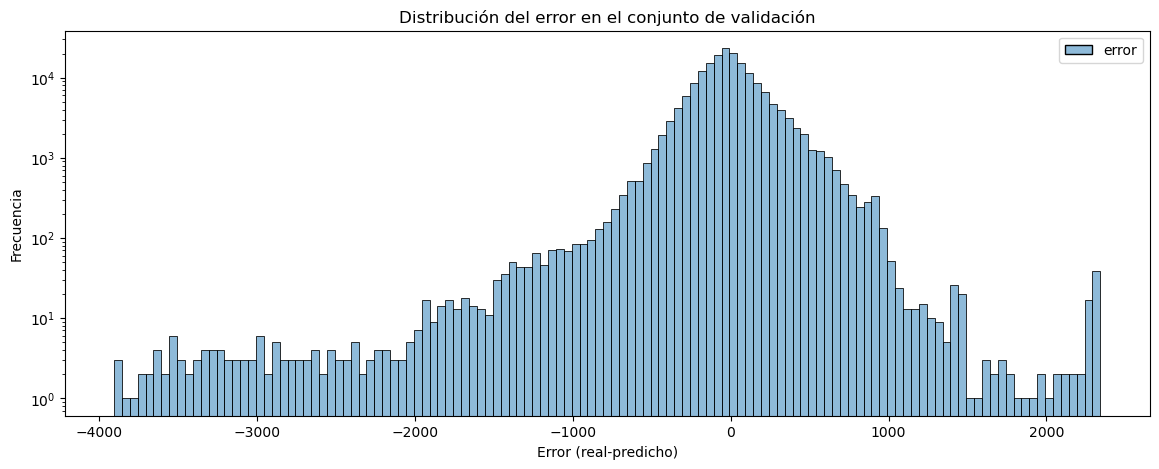

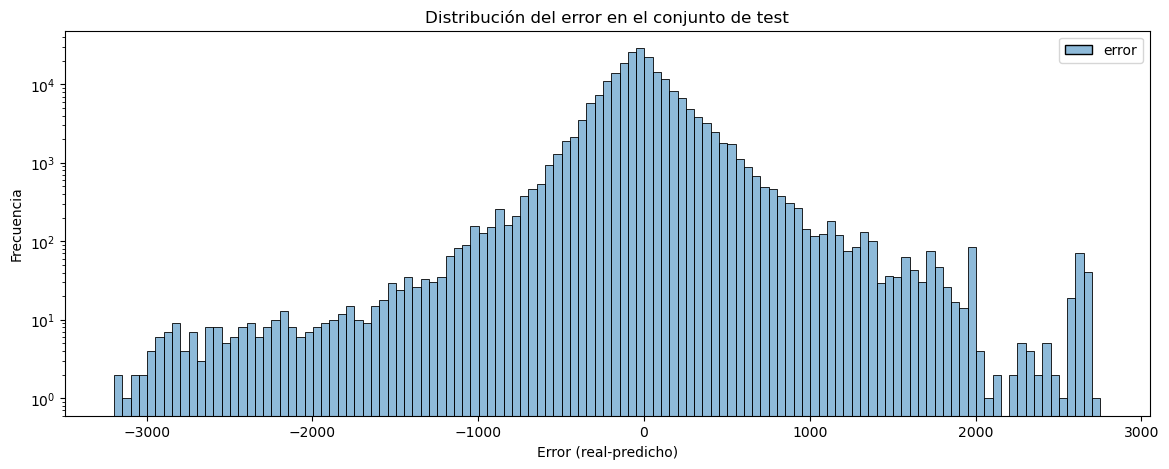

In [13]:
experimento.evaluate(from_parquet=from_parquet, print_err=True)

In [14]:
experimento.evaluate_at_times()

val: Finalizado                                                  
test: Finalizado                                                  


In [15]:
experimento.evaluate_airports()

(40/40)  Done.                                                    


## Generación de informe

In [16]:
from rtaUtils.experiment import report_columns
report_df_long = pd.DataFrame.from_dict(
    experimento.results, orient='index',
    columns=['dataset','time',*report_columns])
report_df = report_df_long.pivot_table(index=['dataset'], columns=['time'], values=report_columns)
report_df.columns = [' '.join((str(y) for y in x)) 
                     for x in report_df.columns.to_flat_index()]
report_df = report_df.reset_index()
# report_df[[x for x in report_df.columns if report_columns[0] in x]]

In [17]:
report_df

,dataset,MAE 0,MAE 15,MAE 30,MAE 60,MAE 90,MAE 120,MAE all,MAPE 0,MAPE 15,...,Sample 90,Sample 120,Sample all,StDev 0,StDev 15,StDev 30,StDev 60,StDev 90,StDev 120,StDev all
0,EBBR,226.482618,144.757106,214.620573,518.981364,NaN,NaN,197.647590,0.068922,0.155898,...,NaN,NaN,8154.0,340.846573,205.374345,303.029142,453.512735,NaN,NaN,316.178047
1,EDDB,257.686013,175.541432,218.946473,225.667857,292.870566,NaN,226.499001,0.044168,0.191086,...,50.0,NaN,13523.0,372.517822,358.513788,327.552385,329.326571,418.726357,NaN,363.987722
2,EDDF,170.927496,102.476758,148.548819,201.115272,NaN,NaN,138.255818,0.044076,0.112136,...,NaN,NaN,10831.0,222.536716,129.472404,195.536747,223.351020,NaN,NaN,192.105117
3,EDDH,195.867926,123.961137,232.699913,214.523148,140.744344,NaN,175.695346,0.039458,0.134651,...,12.0,NaN,7374.0,212.429421,152.793522,294.285221,210.566125,192.197220,NaN,204.432234
4,EDDL,252.016798,128.340287,241.520574,205.292669,NaN,NaN,195.219789,0.066282,0.140381,...,NaN,NaN,9616.0,349.306828,293.770871,366.520751,314.531871,NaN,NaN,338.438926
5,EDDM,212.631808,82.613083,137.128857,220.936516,NaN,NaN,149.662376,0.049613,0.090033,...,NaN,NaN,11682.0,239.346426,97.089206,172.277575,220.541688,NaN,NaN,189.804740
6,EDDP,226.234250,103.178498,131.421510,171.896493,424.879653,NaN,168.443458,0.042787,0.113029,...,17.0,NaN,11637.0,399.471135,142.137618,241.586845,350.086484,648.181008,NaN,367.603268
7,EGCC,355.515215,189.989814,249.027254,292.599854,NaN,NaN,232.280368,0.096680,0.208338,...,NaN,NaN,2547.0,249.700263,222.875294,233.946779,254.346275,NaN,NaN,241.553263
8,EGKK,376.415028,231.514457,394.757778,NaN,NaN,NaN,278.101654,0.138063,0.252587,...,NaN,NaN,2626.0,256.668588,211.674185,297.643444,NaN,NaN,NaN,264.347900
9,EGLL,414.496127,198.398277,421.102539,NaN,NaN,NaN,282.005278,0.155081,0.216877,...,NaN,NaN,1766.0,358.257876,197.741122,444.640857,NaN,NaN,NaN,351.227340


In [18]:
report_df.to_csv(f'./results/{model_type}_s{sampling}_lb{lookback}_u{n_units}.csv', 
                 header=True, encoding='utf8')

## Visualización

In [19]:
import plotly.express as px

In [20]:
report_df = pd.read_csv(f'./results/{model_type}_s{sampling}_lb{lookback}_u{n_units}.csv', 
                        header=0, encoding='utf8')

In [21]:
vis = pd.merge(
    report_df[['MAE all','RMSE all','MAPE all', 'StDev all','Mean all','dataset']],
    pd.read_csv('./data/airports.csv', sep = ','),
    left_on='dataset', right_on='id'
)

In [22]:
td = data_loading.load_final_data(months, 'test')[['aerodromeOfDeparture', 'fpId']].drop_duplicates()\
              .groupby('aerodromeOfDeparture').count()

vis = pd.merge(vis, td, left_on='dataset', right_on='aerodromeOfDeparture')

MemoryError: Unable to allocate 22.2 MiB for an array with shape (2906732, 1) and data type float64

In [ ]:
px.scatter_mapbox(vis, 'lat', 'lon', zoom=3.6,width=950, height=750,
                  mapbox_style="open-street-map", opacity = 1,
                  color = 'MAE all', size='fpId',
#                   range_color=(50,300),
                  # color_continuous_scale='RdYlGn_r', #'bluered' 'Portland'
                  # color_continuous_midpoint=150,
                  hover_data = {'MAE all':':.3f',
                                'RMSE all':':.3f'},
                  hover_name='dataset'
                 )

In [ ]:
px.scatter_mapbox(vis, 'lat', 'lon', zoom=3.6,width=950, height=750,
                  mapbox_style="open-street-map", opacity = 1,
                  color = 'MAPE all', size='fpId',
                  # range_color=(0,0.2),
                  # color_continuous_scale='RdYlGn_r', #'bluered' 'Portland'
                  # color_continuous_midpoint=150,
                  hover_data = {'MAE all':':.3f',
                                'RMSE all':':.3f'},
                  hover_name='dataset'
                 )